In [1]:
from src.experiments import init_dataset
random_state = 42

german = init_dataset('german', 42)
adult = init_dataset('adult', 42)
bank = init_dataset('bank', 42)

In [2]:
def get_features_groups_target(df, dataset):
    features = df[[c for c in df.columns if c not in [*dataset.sensitive, dataset.target]]]
    sensitive = df[dataset.sensitive]
    target = df[[dataset.target]]
    return features, sensitive, target

In [3]:
german_df = german.perform_encoding('cont_ord_cat', german.data, german.data)
adult_df = adult.perform_encoding('cont_ord_cat', adult.data, adult.data)
bank_df = bank.perform_encoding('cont_ord_cat', bank.data, bank.data)

german_features, german_sensitive, german_target = get_features_groups_target(german_df, german)
adult_features, adult_sensitive, adult_target = get_features_groups_target(adult_df, adult)
bank_features, bank_sensitive, bank_target = get_features_groups_target(bank_df, bank)

In [4]:
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA


def pca_visualization(features, sensitive, target):
    pca = PCA(n_components=2)
    pca.fit(features)
    print(pca.explained_variance_ratio_)
    pca_features = pca.transform(features)
    sensitive_groups = sensitive.astype('str').agg('_'.join, axis=1)
    group_class = [f'{t}_{s}' for t, s in zip(target, sensitive_groups)]    
    PC1 = pca_features[:,0]
    PC2 = pca_features[:,1]
    df = pd.DataFrame({'PC1': PC1, 'PC2': PC2, 'target': target, 'sensitive_groups': sensitive_groups, 'group_class': group_class})
    sns.scatterplot(df, x='PC1', y='PC2', hue='group_class')

[0.14280772 0.11168434]


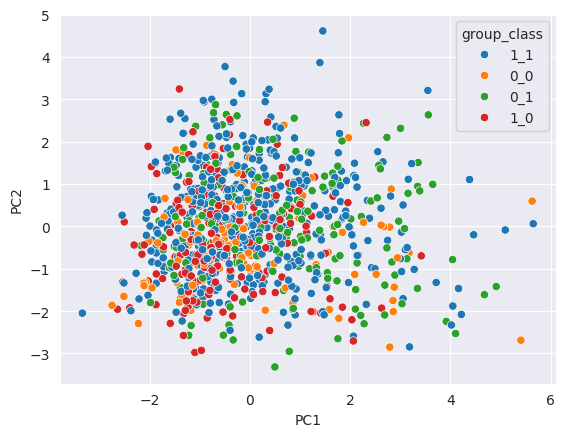

In [5]:
pca_visualization(german_features, german_sensitive, german_target[german.target])

In [6]:
# german_df = german.data
# adult_df = adult.data
# bank_df = bank.data
# 
# german_features, german_sensitive, german_target = get_features_groups_target(german_df, german)
# adult_features, adult_sensitive, adult_target = get_features_groups_target(adult_df, adult)
# bank_features, bank_sensitive, bank_target = get_features_groups_target(bank_df, bank)

In [26]:
import numpy as np
from sklearn.cluster import DBSCAN, KMeans
from distython import HEOM

def clustering(dataset, df):
    cl = KMeans(n_clusters=2, random_state=42, n_init=10)
    cl.fit(df)
    return cl.labels_

In [27]:
def PCA2(features, sensitive, target, cluster):
    pca = PCA(n_components=2)
    pca.fit(features)
    print(pca.explained_variance_ratio_)
    pca_features = pca.transform(features)
    sensitive_groups = sensitive.astype('str').agg('_'.join, axis=1)
    group_class = [f'{t}_{s}' for t, s in zip(target, sensitive_groups)] 
    PC1 = pca_features[:,0]
    PC2 = pca_features[:,1]
    df = pd.DataFrame({'PC1': PC1, 'PC2': PC2, 'target': target, 'sensitive_groups': sensitive_groups, 'group_class': group_class, 'clustering': cluster.astype('str')})
    sns.scatterplot(df, x='PC1', y='PC2', hue='clustering')

1000 1000
[0.14280772 0.11168434]


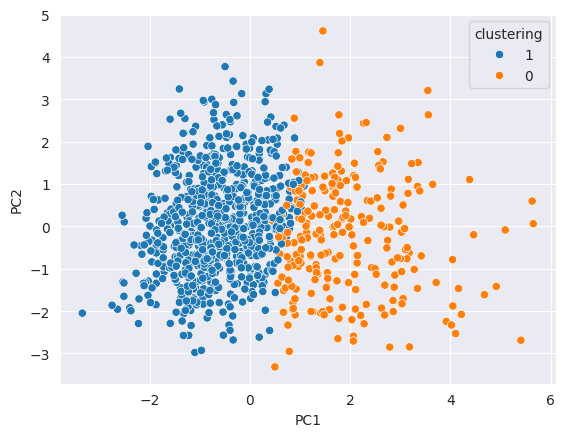

In [28]:
german_clustering = clustering(german, german_features)
print(len(german_clustering), len(german_df))

PCA2(german_features, german_sensitive, german_target[german.target], german_clustering)